# Creating various plots of observed vs predicted values

These include:

- Boxplots, distrbutions

- comparing annual means between predictions and EC tower data

- compare seasonal cycle at each site

- compare EC sites with predictions from other products


## Load modules

In [ ]:
import sys
import os
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sb
import geopandas as gpd
import xarray as xr
from scipy import stats
from scipy.stats import skew
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer

import matplotlib.pyplot as plt
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_training_data import extract_ec_gridded_data

## Product 1:1 intercompariosn

Extract flux values from many products

The easist way to do this is to use our training data extraction procedure but use it extract pixel values from other products

In [ ]:
suffixes = [
    'Emerald/2022_v2/L6/default/Emerald_L6_20110610_20131231_Monthly.nc',
    'GreatWesternWoodlands/2022_v2/L6/default/GreatWesternWoodlands_L6_20130101_20220601_Monthly.nc',
    'CowBay/2022_v2/L6/default/CowBay_L6_20090101_20220816_Monthly.nc',
    'Tumbarumba/2022_v2/L6/default/Tumbarumba_L6_20020107_20220530_Monthly.nc',
    'Whroo/2022_v2/L6/default/Whroo_L6_20111201_20220821_Monthly.nc',
    'WombatStateForest/2022_v2/L6/default/WombatStateForest_L6_20100120_20210529_Monthly.nc',
    'WallabyCreek/2022_v2/L6/default/WallabyCreek_L6_20050825_20130409_Monthly.nc',
    'RobsonCreek/2022_v2/L6/default/RobsonCreek_L6_20130801_20220816_Monthly.nc',
    'CapeTribulation/2022_v2/L6/default/CapeTribulation_L6_20100101_20181102_Monthly.nc',
    'AliceSpringsMulga/2022_v2/L6/default/AliceSpringsMulga_L6_20100903_20220806_Monthly.nc',
    'CalperumChowilla/2022_v2/L6/default/Calperum_L6_20100730_20220829_Monthly.nc',
    'DryRiver/2022_v2/L6/default/DryRiver_L6_20091025_20220820_Monthly.nc',
    'Litchfield/2022_v2/L6/default/Litchfield_L6_20150623_20220513_Monthly.nc',
    'SturtPlains/2022_v2/L6/default/SturtPlains_L6_20080828_20220513_Monthly.nc',
    'RiggsCreek/2022_v2/L6/default/RiggsCreek_L6_20110101_20170712_Monthly.nc', #dryland cropping
    'Otway/2022_v2/L6/default/Otway_L6_20070811_20110101_Monthly.nc', # pasture site
    'Yanco/2022_v2/L6/default/Yanco_L6_20130101_20220821_Monthly.nc', # soil site
    
    ## check the location of these ones below as they are new additions
    'Gingin/2022_v2/L6/default/Gingin_L6_20111013_20210614_Monthly.nc', # native Banksia woodland
    'LongreachMitchellGrassRangeland/2022_v2/L6/default/Longreach_L6_20181009_20220607_Monthly.nc',
    'Ridgefield/2022_v2/L6/default/Ridgefield_L6_20160101_20220821_Monthly.nc', #  dryland agriculture
    'SilverPlains/2022_v2/L6/default/SilverPlains_L6_20200101_20211231_Monthly.nc', #Australian Mountain Reseach 
    'Collie/2022_v2/L6/default/Collie_L6_20170804_20191111_Monthly.nc', # wandoo woodland
    'AdelaideRiver/2022_v2/L6/default/AdelaideRiver_L6_20071017_20090524_Monthly.nc', #  Savanna dominated by Eucalyptus
    'Warra/2022_v2/L6/default/Warra_L6_20130305_20210921_Monthly.nc', #tasmania
    
    ### ----------Problematic sites--------
    #'DalyPasture/2022_v2/L6/default/DalyPasture_L6_20080101_20130908_Monthly.nc', #fragmented landscape, pasture among native veg fragments
    #'DalyUncleared/2022_v1/L6/default/DalyUncleared_L6_20080101_20220217_Monthly.nc', #Woodland savanna LOTS OF UNCERTAINTY IN THIS SITE - Peter Isaac
    'CumberlandPlain/2022_v2/L6/default/CumberlandPlain_L6_20140101_20220820_Monthly.nc',# small remnant bushland block in ag district
    'SamfordEcologicalResearchFacility/2022_v2/L6/default/Samford_L6_20100602_20171231_Monthly.nc', #fragmented landscape 5km resolution not good enough
    'Boyagin/2022_v2/L6/default/Boyagin_L6_20171020_20220821_Monthly.nc', # in remnant forest around crops, BORDERLINE MIGHT BE OKAY
    'TiTreeEast/2022_v1/L6/default/TiTreeEast_L6_20120718_20220117_Monthly.nc', 
    #'RedDirtMelonFarm/2021_v1/L6/default/RedDirtMelonFarm_L6_20110923_20130721_Monthly.nc', #small farm in the middle of savannah woodland
    'FoggDam/2022_v2/L6/default/FoggDam_L6_20060207_20081031_Monthly.nc', # wetland that floods seasonally
    #'Loxton/2022_v1/L6/default/Loxton_L6_20080819_20090609_Monthly.nc' # almond tress, 1 year of data
]

i=0
sites = []
for suffix in suffixes:
    print(" {:02}/{:02}\r".format(i + 1, len(suffixes)), end="")
    xx = extract_ec_gridded_data(suffix,
                                 covariables=['kNDVI'],
                                 scale='1km',
                                 save_ec_data=False,
                                 verbose=False,
                                 add_comparisons=True,
                                 export_path='/g/data/os22/chad_tmp/NEE_modelling/results/harmonized/'
                                )
    sites.append(xx)
    i+=1

### Stitich together other products data in a df

In [ ]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/harmonized/'
sites = os.listdir(base)

td = []
for site in sites:
    if '.csv' in site:
        xx = pd.read_csv(base+site, index_col='time', parse_dates=True)
        xx['site'] = site[0:5]
        td.append(xx)

df = pd.concat(td)

In [ ]:
df = df[['NEE_SOLO_EC', 'GPP_SOLO_EC', 'ER_SOLO_EC',
         'FLUXCOM_RS_NEE','FLUXCOM_RS_GPP', 'FLUXCOM_RS_ER',
         'FLUXCOM_MET_NEE','FLUXCOM_MET_GPP', 'FLUXCOM_MET_ER',
         'CABLE_BIOS_NEE', 'CABLE_BIOS_GPP', 'CABLE_BIOS_ER',
         'CABLE_POP_NEE', 'CABLE_POP_GPP', 'CABLE_POP_ER',
         'GOSIF_GPP', 'DIFFUSE_GPP', 'MODIS_GPP',
         'This_Study_NEE', 'This_Study_GPP', 'This_Study_ER',
         'site'
        ]]

df = df.dropna()
df

### Plot

In [ ]:
var='NEE'
font=24

In [ ]:
if var == 'GPP':
    products=['CABLE_BIOS_'+var, 'FLUXCOM_MET_'+var, 'FLUXCOM_RS_'+var, 'MODIS_'+var, 'GOSIF_'+var, 'DIFFUSE_'+var] #
    fig,axes = plt.subplots(2,3, figsize=(18,12), sharey=True, sharex=True)
    
else:
    products=['CABLE_BIOS_'+var, 'FLUXCOM_MET_'+var, 'FLUXCOM_RS_'+var] #'This_Study_'+var,
    fig,axes = plt.subplots(1,3, figsize=(18,7), sharey=True, sharex=True)

for prod, ax in zip(products, axes.ravel()):
    
    obs,pred = df[var+'_SOLO_EC'].values, df[prod].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    r2 = r_value**2
    # r2 = r2_score(obs, pred)
    # r2 = sp.stats.pearsonr(obs, pred)
    ac = mean_absolute_error(obs, pred)
    
    xy = np.vstack([obs,pred])
    z = gaussian_kde(xy)(xy)

    sb.scatterplot(data=df, x=var+'_SOLO_EC',y=prod, c=z, s=50, lw=1, alpha=0.5, ax=ax)
    sb.regplot(data=df, x=var+'_SOLO_EC',y=prod, scatter=False, color='blue', ax=ax)
    sb.regplot(data=df, x=var+'_SOLO_EC',y=var+'_SOLO_EC', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
    ax.set_title(prod, fontsize=font)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_aspect(1.5)
    ax.text(.05, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=font)
    ax.text(.05, .825, 'MAE={:.3g}'.format(np.mean(ac)),
            transform=ax.transAxes, fontsize=font)
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)

fig.supylabel('Predicted '+var+' gC m\N{SUPERSCRIPT TWO} m⁻¹', fontsize=font)
fig.supxlabel('Observed '+var+' gC m\N{SUPERSCRIPT TWO} m⁻¹', fontsize=font, y=0.025);
plt.tight_layout(pad=1.75)
fig.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/cross_val_intercomparison_'+var+'.png', bbox_inches='tight')

## Comparing our predictions with site-level data

### Analysis Params


In [2]:
var = 'NEE'
suffix = '20230320'

### Open predictions

In [3]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+var+'_2003_2022_1km_quantiles_'+suffix+'.nc').sel(quantile=0.5)

In [4]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/training_data/'
sites = os.listdir('/g/data/os22/chad_tmp/NEE_modelling/results/training_data/')

td = []
for site in sites:
    if '.csv' in site:
        xx = pd.read_csv(base+site, index_col='time', parse_dates=True)
        
        # indexing spatiotemporal values at EC site
        lat = xx['y_coord'].values[0]
        lon = xx['x_coord'].values[0]
        time_start = str(np.datetime_as_string(xx.index.values[0], unit='D'))
        time_end = str(np.datetime_as_string(xx.index.values[-1], unit='D'))
        idx=dict(y=lat,  x=lon)
        
        da = ds.sel(idx, method='nearest').sel(time=slice(time_start, time_end)) # grab pixel
        da = da.reindex(time=xx.index, method='nearest', tolerance='1D').compute() 
        da = da.rename(var+'_prediction').to_dataframe().drop(['y', 'x', 'spatial_ref'], axis=1)
        xx = xx.join(da)
        xx['site'] = site[0:5]
        
        td.append(xx)

ts = pd.concat(td)#.dropna()

### Compare distributions

In [ ]:
hist = ts[[var+'_SOLO_EC', var+'_prediction']].rename({var+'_SOLO_EC':'Observed', var+'_prediction':'Prediction'}, axis=1)
sb.displot(hist, kind="kde", fill=True)
plt.xlabel(var+' (gC m\N{SUPERSCRIPT TWO} m⁻¹)', fontsize=15)
plt.ylabel('Density', fontsize=12)
if var=='NEE':
    plt.axvline(0, c='grey', linestyle='--')
plt.tight_layout()
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_kde_obs_pred.png')

### Convert to annual means

In [ ]:
df = ts.groupby('site').resample('Y').mean()

df = df[[var+'_SOLO_EC', var+'_prediction']]
df = df.rename({var+'_SOLO_EC':'obs', var+'_prediction':'pred'}, axis=1)

### Per site annual mean boxplots

In [ ]:
fig, ax =  plt.subplots(4,8,figsize=(23,10), sharex=True)
df.groupby('site').boxplot(subplots=True, ax=ax.flatten()[:29], rot=0, grid=False, fontsize=12)
if var == 'NEE':
    for a in ax.reshape(-1): 
        a.axhline(0, c='grey', linestyle='--');
fig.supylabel('Annual '+var+' (gC m\N{SUPERSCRIPT TWO} m⁻¹)', fontsize=16)
plt.tight_layout()
# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_boxplots_annualmean.png')

### Per site climatology comparison

In [5]:
clim = ts.groupby([ts['site'], ts.index.month]).mean()
clim = clim[[var+'_SOLO_EC', var+'_prediction']]
clim = clim.rename({var+'_SOLO_EC':'obs', var+'_prediction':'pred'}, axis=1)

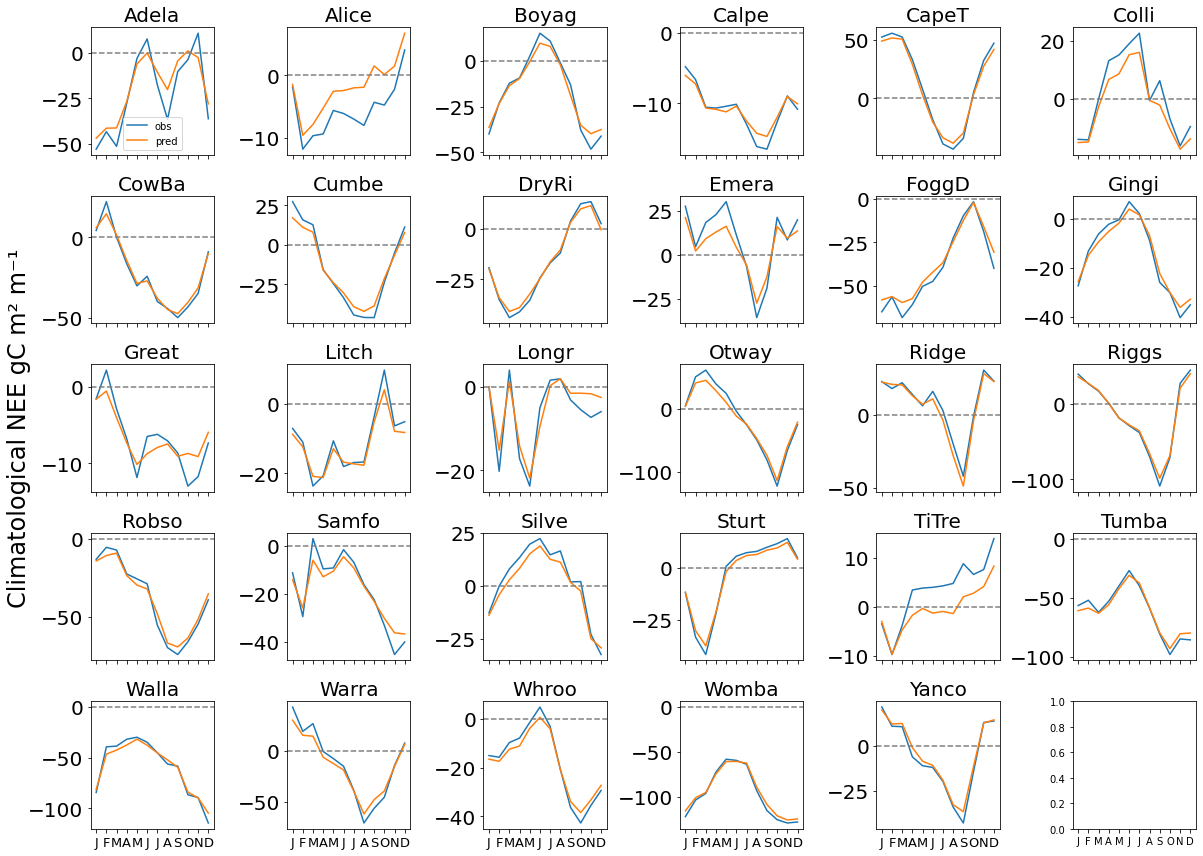

In [15]:
fig, ax =  plt.subplots(5,6,figsize=(17,12), sharex=True)

for a, b in zip(ax.reshape(-1), clim.groupby('site')): 
    label, df = b[0], b[1] 
    if label=='Adela':   
        df.plot(kind="line", ax=a, label=label, legend=True)
    else:
        df.plot(kind="line", ax=a, label=label, legend=False)
    if var == 'NEE':
        a.axhline(0, c='grey', linestyle='--')
    a.set_xticks(range(0,12))
    a.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=17)
    a.tick_params(axis='x', labelsize=13)
    a.tick_params(axis='y', labelsize=20)
    a.set_title(label, fontdict={'fontsize':20})
    a.set_ylabel('')
    a.set_xlabel('')

fig.supylabel('Climatological '+var+' gC m\N{SUPERSCRIPT TWO} m⁻¹', fontsize=24)

plt.tight_layout()
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/climatology_curves_persite_'+var+'.png')

### 1:1 of annual means 

Using annual monthly, but we can use the annual monthly sum but results are very similar


Plots will be coloured by biome (not site)

In [48]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')
gdf

,bioclimatic_regions,region_name,geometry
0,1.0,Tropics,"MULTIPOLYGON (((122.92500 -16.42500, 122.92500..."
1,2.0,Savanna,"MULTIPOLYGON (((147.67500 -19.87500, 147.72500..."
2,3.0,Warm Temperate,"MULTIPOLYGON (((145.42500 -36.02500, 145.42500..."
3,4.0,Cool Temperate,"MULTIPOLYGON (((147.07500 -43.37500, 147.12500..."
4,5.0,Mediterranean,"MULTIPOLYGON (((135.82500 -34.87500, 135.82500..."
5,6.0,Desert,"MULTIPOLYGON (((113.57500 -26.67500, 113.57500..."


In [49]:
gdf_ts = gpd.GeoDataFrame(
    ts, geometry=gpd.points_from_xy(ts.x_coord, ts.y_coord))

In [50]:
gdf_ts.crs = gdf.crs

In [51]:
gdf_ts = gdf_ts.sjoin(gdf, how="left")

gdf_ts.loc[gdf_ts['site'] == 'CapeT', ['bioclimatic_regions']] = 1.0
gdf_ts.loc[gdf_ts['site'] == 'CowBa', ['bioclimatic_regions']] = 1.0

<AxesSubplot:>

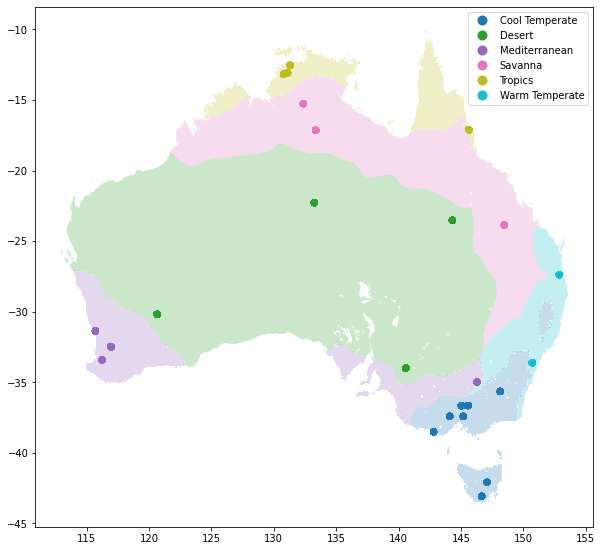

In [52]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
gdf.plot(column='region_name', ax=ax, alpha=0.25)
gdf_ts.plot(ax=ax, column='region_name', legend=True)

### Code for switchin to annual sums


In [53]:
# #seperate regions first so we can do a .sum
# regions = gdf_ts.groupby('site').resample('Y').mean() 
# regions =  regions['bioclimatic_regions']

# #resample to sum over the year
# df = gdf_ts.groupby('site').resample('Y').sum()

# # clean up
# df = df[[var+'_SOLO_EC', var+'_prediction']]
# df = df.rename({var+'_SOLO_EC':'obs', var+'_prediction':'pred'}, axis=1)
# df['bioclimatic_regions'] = regions 
# df = df.dropna()

In [54]:
# gdf_ts.loc[gdf_ts['site'] == 'TiTre'].tail(25)

# df.loc[df['bioclimatic_regions'] == 6.0]

### Calculate annual means

In [55]:
#resample to mean over the year
df = gdf_ts.groupby('site').resample('Y').mean()

# clean up
df = df[[var+'_SOLO_EC', var+'_prediction', 'bioclimatic_regions']]
df = df.rename({var+'_SOLO_EC':'obs', var+'_prediction':'pred'}, axis=1)
df = df.dropna()

### Reclassify region names for nice plotting

In [56]:
df.loc[df['bioclimatic_regions'] == 1.0, ['region']] = 'Tropics'
df.loc[df['bioclimatic_regions'] == 2.0, ['region']] = 'Savanna'
df.loc[df['bioclimatic_regions'] == 3.0, ['region']] = 'Warm Temperate'
df.loc[df['bioclimatic_regions'] == 4.0, ['region']] = 'Cool Temperate'
df.loc[df['bioclimatic_regions'] == 5.0, ['region']] = 'Mediterranean'
df.loc[df['bioclimatic_regions'] == 6.0, ['region']] = 'Desert'


In [57]:
# df.loc[df['bioclimatic_regions'] == 1.0].plot.scatter('obs', 'pred')

### Plot

In [58]:
r2 = r2_score(df['obs'], df['pred'])
ac = mean_absolute_error(df['obs'], df['pred'])

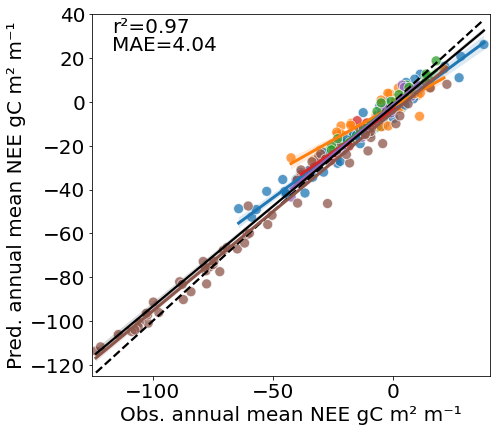

In [59]:
fig,ax = plt.subplots(1,1, figsize=(7,6))

font=20

sb.scatterplot(data=df, x='obs',y='pred', hue='region', s=100, lw=1, ax=ax, alpha=0.75, legend=False) 
sb.regplot(data=df, x='obs',y='obs', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)

for r in df['region'].unique():
    dff = df.loc[df['region']==r]
    sb.regplot(data=dff, x='obs',y='pred', scatter=False, ax=ax, line_kws={'linewidth':3}, label=r)

sb.regplot(data=df, x='obs',y='pred', scatter=False, color='black', ax=ax, label='All Data')    
    
# plt.legend(loc='lower right', fontsize=20, markerscale=2)
plt.xlabel('Obs. annual mean '+ var + ' gC m\N{SUPERSCRIPT TWO} m⁻¹', fontsize=font)
plt.ylabel('Pred. annual mean ' + var+ ' gC m\N{SUPERSCRIPT TWO} m⁻¹', fontsize=font)
ax.text(.05, .95, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=font)
ax.text(.05, .9, 'MAE={:.3g}'.format(np.mean(ac)),
            transform=ax.transAxes, fontsize=font)
if var=='NEE':
    ax.set_ylim(-125, 40)
    ax.set_xlim(-125, 40)
    
ax.tick_params(axis='x', labelsize=font)
ax.tick_params(axis='y', labelsize=font)

plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/"+var+"_annual_mean_onetoone.png", bbox_inches='tight')

In [ ]:
# get handles and labels for reuse
label_params = ax.get_legend_handles_labels() 

figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, loc='best', fontsize=24, markerscale=4, ncol=10)
figl.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/legend_annual_mean_onetoone.png', bbox_inches='tight')


## Older code for comapring distributions

In [ ]:
var = 'NEE'
suffix = '20221212'

In [ ]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/training_data/'
sites = os.listdir('/g/data/os22/chad_tmp/NEE_modelling/results/training_data/')

td = []
for site in sites:
    if '.csv' in site:
        xx = pd.read_csv(base+site, index_col='time', parse_dates=True)
        xx['site'] = site[0:5]
        td.append(xx)

ts = pd.concat(td)#.dropna()
# sites = ts[['site', 'x_coord','y_coord']]
# sites = sites.drop_duplicates().reset_index(drop=True)
# gdf = gpd.GeoDataFrame(
#     sites, geometry=gpd.points_from_xy(sites.x_coord, sites.y_coord), crs='epsg:4326')

# gdf = gdf.drop(['x_coord', 'y_coord'],axis=1)

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(7,5))
sns.distplot(ts.GPP_SOLO_EC, ax=ax, label='GPP')
sns.distplot(ts.ER_SOLO_EC, ax=ax, label='ER')
sns.distplot(ts.NEE_SOLO_EC, ax=ax, label='NEE')
s_nee = skew(ts.NEE_SOLO_EC)
s_gpp = skew(ts.GPP_SOLO_EC)
s_er = skew(ts.ER_SOLO_EC)
ax.legend()
ax.text(.825, .75, 'Skew:',transform=ax.transAxes)
ax.text(.825, .7, 'GPP = {:.3f}'.format(s_gpp),
                transform=ax.transAxes)
ax.text(.825, .65, 'ER = {:.3f}'.format(s_er),
                transform=ax.transAxes)
ax.text(.825, .6, 'NEE = {:.3f}'.format(s_nee),
                transform=ax.transAxes)
ax.set_xlabel('Ozflux Carbon fluxes (gC m\N{SUPERSCRIPT TWO} m⁻¹)')
ax.set_xlim(-225,450)
plt.tight_layout()
#plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/ozflux_carbon_flux_distributions.png');

In [ ]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+var+'_2003_2021_5km_LGBM_'+suffix+'.nc')

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(7,5))
sns.displot(ts.NEE_SOLO_EC, ax=ax, label='Observed')
ds.plot.hist(bins=100, ax=ax, label='predicted')
ax.legend()
ax.set_xlabel(var+' (gC m\N{SUPERSCRIPT TWO} m⁻¹)')
# ax.set_xlim(-225,450)
plt.tight_layout()
ds.plot.hist(bins=100);

In [ ]:
sns.displot(ds, label='NEE')

### Power transform distributions to enforce normality

In [ ]:
nee = ts.NEE_SOLO_EC.values.reshape(-1, 1)
gpp = ts.GPP_SOLO_EC.values.reshape(-1, 1)
er = ts.ER_SOLO_EC.values.reshape(-1, 1)

In [ ]:
bc.inverse_transform

In [ ]:
bc = PowerTransformer(method="yeo-johnson")

nee_transformed = bc.fit(nee).transform(nee)
gpp_transformed = bc.fit(gpp).transform(gpp)
er_transformed = bc.fit(er).transform(er)

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(7,5))
sns.distplot(gpp_transformed, ax=ax, label='GPP')
sns.distplot(er_transformed, ax=ax, label='ER')
sns.distplot(nee_transformed, ax=ax, label='NEE')
s_nee = skew(nee_transformed)
s_gpp = skew(gpp_transformed)
s_er = skew(er_transformed)

ax.legend()

ax.text(.825, .75, 'Skew:',transform=ax.transAxes)
ax.text(.825, .7, 'GPP = {:.3f}'.format(s_gpp[0]),
                transform=ax.transAxes)
ax.text(.825, .65, 'ER = {:.3f}'.format(s_er[0]),
                transform=ax.transAxes)
ax.text(.825, .6, 'NEE = {:.3f}'.format(s_nee[0]),
                transform=ax.transAxes)
ax.set_xlabel('Ozflux Carbon fluxes (gC m\N{SUPERSCRIPT TWO} m⁻¹)')
# ax.set_xlim(-225,450)
plt.tight_layout()
